In [56]:
import os

# os.environ["MODIN_ENGINE"] = "ray"
from datetime import datetime, timedelta, timezone
from itertools import cycle, islice

# import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import cluster
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sqlalchemy.orm import Session
from sqlalchemy import select

from utils.db_utils import DB_ENGINE, Category, Restaurant, Item

In [57]:
with Session(DB_ENGINE) as session:
    query = select(Category)
    category_df = pd.read_sql_query(query, session.bind)
    query = select(Restaurant)
    restaurant_df = pd.read_sql_query(query, session.bind)
    query = select(Item)
    # session.query(Item).delete()
    item_df = pd.read_sql_query(query, session.bind)
    # cur = db_con.execute("SELECT * FROM items")
    # results = cur.fetchall()
    # UTC is 8 hours ahead of PT
    # pt_now = datetime.now(timezone.utc) - timedelta(hours=8)
    # db_df.to_csv(f"items_{pt_now.isoformat()}.csv")


In [58]:
category_df

,id,name,rel_url
0,1,24 Hours Food,/category/emeryville-ca/24-hours
1,2,Acai food,/category/emeryville-ca/acai
2,3,Afghan Food,/category/emeryville-ca/afghan
3,4,African Food,/category/emeryville-ca/african
4,5,Alcohol,/category/emeryville-ca/alcohol
...,...,...,...
963,964,Wine,/category/oakland-ca/wine
964,965,Wings,/category/oakland-ca/wings
965,966,Wraps,/category/oakland-ca/wrap
966,967,Japanese BBQ,/category/oakland-ca/yakiniku


In [59]:
category_df['name'].nunique()

196

In [60]:
restaurant_df

,id,name,rating,rel_url,category_id
0,1,Acai Aura (2353 E 12th St),2.8,/store/acai-aura-2353-e-12th-st/0K9ccjlkQCC9H4...,2
1,2,Gunpowder Cafe (2353 E 12th St Kitchen),0.0,/store/gunpowder-cafe-2353-e-12th-st-kitchen/p...,2
2,3,The Vegan Breakfast,0.0,/store/the-vegan-breakfast/6X67tuc5Tg-lCm53Ev9SLA,2
3,4,Marina Supermarket,0.0,/store/marina-supermarket/zhWQdjpvVseZsSkURyDAXA,2
4,5,Jay Vee Liquors,4.8,/store/jay-vee-liquors/GzwW2nC8TCSA4LulH9insA,2
...,...,...,...,...,...
517,518,Spices,4.8,/store/spices/lszSibfTSlu-uoUiB1g2aA,369
518,519,Happy Lemon (San Leandro),4.8,/store/happy-lemon-san-leandro/a-stL3BHXpiSqZU...,369
519,520,"Yi Fang Taiwan Fruit Tea, Colma",4.9,/store/yi-fang-taiwan-fruit-tea-colma/0CdB9Sgq...,369
520,521,Flaming Kitchen,0.0,/store/flaming-kitchen/8-d3mOH8RwijZU2ztOLYoQ,369


In [61]:
# for _, item in item_df.iterrows():
#     if item["name"] is None:
#         print(item["rel_url"],"\n")
item_df

,id,name,description,rel_url,restaurant_id
0,1,Cheese Quesadilla,"Flour tortillas, mixed cheeses, black olives, ...","Cheese QuesadillaFlour tortillas, mixed cheese...",257
1,2,Kale Caesar Salad,"Kale lettuce, croutons, parmesan cheese, caesa...","Kale Caesar SaladKale lettuce, croutons, parme...",257
2,3,Chicken Cobb Salad,"Chopped greens, tomato, crisp bacon, hardboile...","Chicken Cobb SaladChopped greens, tomato, cris...",257
3,4,BBQ Chicken Salad,"Mix green lettuce, red onions, tomatoes, mix c...","BBQ Chicken SaladMix green lettuce, red onions...",257
4,5,Mediterranean Chicken Salad,"Romaine lettuce, feta cheese, black olives, to...","Mediterranean Chicken SaladRomaine lettuce, fe...",257
...,...,...,...,...,...
1919,1920,Bud Light,,Bud Light+120,120
1920,1921,Miller,,Miller+120,120
1921,1922,White,,White+120,120
1922,1923,Burgundy,,Burgundy+120,120


In [62]:
def extract_city_from_category_url(row):
    # ex category_rel_url: /category/emeryville-ca/african
    return row["rel_url"].split("/", 3)[2].rsplit("-", 1)[0].title()


category_df["city"] = category_df.apply(lambda row: extract_city_from_category_url(row), axis=1)
category_df.head()

,id,name,rel_url,city
0,1,24 Hours Food,/category/emeryville-ca/24-hours,Emeryville
1,2,Acai food,/category/emeryville-ca/acai,Emeryville
2,3,Afghan Food,/category/emeryville-ca/afghan,Emeryville
3,4,African Food,/category/emeryville-ca/african,Emeryville
4,5,Alcohol,/category/emeryville-ca/alcohol,Emeryville


In [63]:
category_df.groupby(["city"]).size()

city
Alameda       193
Albany        195
Berkeley      193
Emeryville    193
Oakland       194
dtype: int64

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 4.29 µs


([], [])

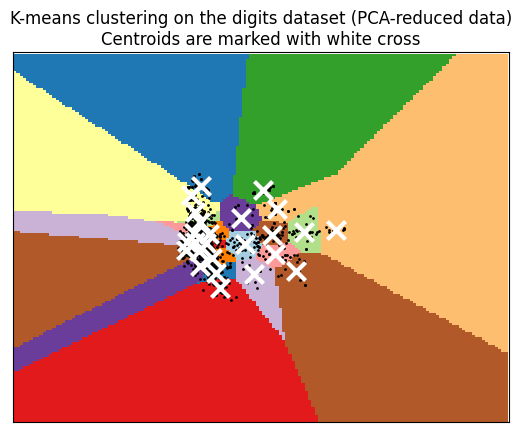

In [69]:
%time

full_item_desc_col = item_df["name"] + " " + item_df["description"]
lsa_vectorizer = make_pipeline(
    HashingVectorizer(stop_words="english", n_features=50_000),
    TfidfTransformer(),
    TruncatedSVD(n_components=100, random_state=0),
    Normalizer(copy=False),
)

fit_transform_data = lsa_vectorizer.fit_transform(full_item_desc_col)

reduced_data = PCA(n_components=2).fit_transform(fit_transform_data)
kmeans = cluster.KMeans(init="k-means++", n_clusters=25, n_init=5)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

In [67]:
# original_space_centroids = lsa_vectorizer[0].inverse_transform(kmeans.cluster_centers_)
# order_centroids = original_space_centroids.argsort()[:, ::-1]
# terms = vectorizer.get_feature_names_out()

# for i in range(true_k):
#     print(f"Cluster {i}: ", end="")
#     for ind in order_centroids[i, :10]:
#         print(f"{terms[ind]} ", end="")
#     print()
Z

array([[12, 12, 12, ...,  1,  1,  1],
       [12, 12, 12, ...,  1,  1,  1],
       [12, 12, 12, ...,  1,  1,  1],
       ...,
       [13, 13, 13, ..., 14, 14, 14],
       [13, 13, 13, ..., 14, 14, 14],
       [13, 13, 13, ..., 14, 14, 14]], dtype=int32)